# Metric 1 : Quarterly comparison of metadata on files with a common template, such as the information template and artwork template

In continuation to the numbers we provided in T231952-part-1b for Structured data on Commons, we will look into getting the number of properties added to Commons files on average. 

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

from wmfdata import hive, mariadb

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
# needed to show matplot plots?
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import colors

### Configuration Variables

In [3]:
wmf_snapshot = '2019-11'
start_date = '2019-01-01' # first date of caption edits
start_date_new = '2019-07-31' # first date of caption edits
end_date = '2019-12-01' # last date of caption edits (exclusive)

### Mapping of distinct page IDs to the 7 properties that we are interested in:
1. Caption P2096
2. Date of Creation P571
3. Date of Publication P577
4. Creator P170
5. License P275
6. Digital Representation of P6243
7. Depicts P180

In [5]:
map_query = '''
WITH all_pages AS (
    SELECT distinct page_id
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db = "commonswiki"
    AND event_entity = "revision"
    AND event_type = "create"
    AND event_timestamp >= "2019-07-31"
    AND event_timestamp < "2019-12-01"
    AND page_is_deleted = false -- only count live pages
    AND page_namespace = 6 -- only count files
),

label_pages AS (
    SELECT distinct page_id, 1 AS has_label
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db = "commonswiki"
    AND event_entity = "revision"
    AND event_type = "create"
    AND event_timestamp >= "2019-07-31"
    AND event_timestamp < "2019-12-01"
    AND page_is_deleted = false -- only count live pages
    AND page_namespace = 6 -- only count files
    AND event_comment REGEXP "^...wbsetlabel-(add|set):"
),

depicts_pages AS (
    SELECT distinct page_id, 1 AS has_depicts
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db = "commonswiki"
    AND event_entity = "revision"
    AND event_type = "create"
    AND event_timestamp >= "2019-07-31"
    AND event_timestamp < "2019-12-01"
    AND page_is_deleted = false -- only count live pages
    AND page_namespace = 6 -- only count files
    AND (event_comment REGEXP "^...wbcreateclaim-create:"
         OR event_comment REGEXP "^...wbeditentity-update:"
         OR event_comment REGEXP "^...wbsetclaim-create:"
         OR event_comment REGEXP "^...wbsetclaim-update:"
    )
    AND event_comment LIKE "%P180%"
),

creator_pages AS (
    SELECT distinct page_id, 1 AS has_creator
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db = "commonswiki"
    AND event_entity = "revision"
    AND event_type = "create"
    AND event_timestamp >= "2019-07-31"
    AND event_timestamp < "2019-12-01"
    AND page_is_deleted = false -- only count live pages
    AND page_namespace = 6 -- only count files
    AND (event_comment REGEXP "^...wbcreateclaim-create:"
    OR event_comment REGEXP "^...wbeditentity-update:"
    OR event_comment REGEXP "^...wbsetclaim-create:"
    OR event_comment REGEXP "^...wbsetclaim-update:"
    )
    AND event_comment LIKE "%P170%"

),

date_creation_pages AS (
    SELECT distinct page_id, 1 AS has_creation_date
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db = "commonswiki"
    AND event_entity = "revision"
    AND event_type = "create"
    AND event_timestamp >= "2019-07-31"
    AND event_timestamp < "2019-12-01"
    AND page_is_deleted = false -- only count live pages
    AND page_namespace = 6 -- only count files
    AND (event_comment REGEXP "^...wbcreateclaim-create:"
    OR event_comment REGEXP "^...wbeditentity-update:"
    OR event_comment REGEXP "^...wbsetclaim-create:"
    OR event_comment REGEXP "^...wbsetclaim-update:"
    )
    AND event_comment like "%P571%"
    
),

date_publication_pages AS (
    SELECT distinct page_id, 1 AS has_publication_date
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db = "commonswiki"
    AND event_entity = "revision"
    AND event_type = "create"
    AND event_timestamp >= "2019-07-31"
    AND event_timestamp < "2019-12-01"
    AND page_is_deleted = false -- only count live pages
    AND page_namespace = 6 -- only count files
    AND (event_comment REGEXP "^...wbcreateclaim-create:"
    OR event_comment REGEXP "^...wbeditentity-update:"
    OR event_comment REGEXP "^...wbsetclaim-create:"
    OR event_comment REGEXP "^...wbsetclaim-update:"
    )
    AND event_comment like "%P577%"
),

license_pages AS (
    SELECT distinct page_id, 1 AS has_license
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db = "commonswiki"
    AND event_entity = "revision"
    AND event_type = "create"
    AND event_timestamp >= "2019-07-31"
    AND event_timestamp < "2019-12-01"
    AND page_is_deleted = false -- only count live pages
    AND page_namespace = 6 -- only count files
    AND (event_comment REGEXP "^...wbcreateclaim-create:"
    OR event_comment REGEXP "^...wbeditentity-update:"
    OR event_comment REGEXP "^...wbsetclaim-create:"
    OR event_comment REGEXP "^...wbsetclaim-update:"
    )
    AND event_comment like "%P275%"
    
),

digital_representation_pages AS (
    SELECT distinct page_id, 1 AS has_digital_rep
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db = "commonswiki"
    AND event_entity = "revision"
    AND event_type = "create"
    AND event_timestamp >= "2019-07-31"
    AND event_timestamp < "2019-12-01"
    AND page_is_deleted = false -- only count live pages
    AND page_namespace = 6 -- only count files
    AND (event_comment REGEXP "^...wbcreateclaim-create:"
    OR event_comment REGEXP "^...wbeditentity-update:"
    OR event_comment REGEXP "^...wbsetclaim-create:"
    OR event_comment REGEXP "^...wbsetclaim-update:"
    )
    AND event_comment like "%P6243%"
)

-- added all the properties above...

SELECT distinct all_pages.page_id,
  has_label, 
  has_depicts,
  has_creator,
  has_creation_date,
  has_publication_date,
  has_license,
  has_digital_rep
FROM all_pages
LEFT JOIN label_pages
ON label_pages.page_id=all_pages.page_id
LEFT JOIN depicts_pages
ON depicts_pages.page_id=all_pages.page_id
LEFT JOIN creator_pages
ON creator_pages.page_id=all_pages.page_id
LEFT JOIN date_creation_pages
ON date_creation_pages.page_id=all_pages.page_id
LEFT JOIN date_publication_pages
ON date_publication_pages.page_id=all_pages.page_id
LEFT JOIN license_pages
ON license_pages.page_id=all_pages.page_id
LEFT JOIN digital_representation_pages
ON digital_representation_pages.page_id=all_pages.page_id
WHERE (has_label IS NOT NULL
       OR has_depicts IS NOT NULL
       OR has_creator IS NOT NULL
       OR has_creation_date IS NOT NULL
       OR has_publication_date IS NOT NULL
       OR has_license IS NOT NULL
       OR has_digital_rep IS NOT NULL
       )

'''

In [6]:
property_page_id= hive.run(
    [
        "SET mapreduce.map.memory.mb=4096", 
        "SET hive.mapred.mode=nonstrict",
        map_query.format(
            snapshot = wmf_snapshot 
        )
    ]
)


In [7]:
property_page_id=property_page_id.fillna(0)
property_page_id.tail()

,page_id,has_label,has_depicts,has_creator,has_creation_date,has_publication_date,has_license,has_digital_rep
1345937,84508434,1.0,1.0,0.0,0.0,0,0.0,0.0
1345938,84508442,1.0,0.0,0.0,0.0,0,0.0,0.0
1345939,84508443,1.0,0.0,0.0,0.0,0,0.0,0.0
1345940,84508489,1.0,0.0,0.0,0.0,0,0.0,0.0
1345941,84508509,1.0,0.0,0.0,0.0,0,0.0,0.0


### Getting the total number of properties for each page
Note: We're dropping the publication date property from our calculations since it looks like there isn't any file that has this property

In [8]:


property_page_id['num_props'] = (property_page_id['has_label'] + 
                                 property_page_id['has_depicts']+
                                 property_page_id['has_creator']+
                                 property_page_id['has_creation_date'] + 
                                 property_page_id['has_license'] + 
                                 property_page_id['has_digital_rep'])

In [9]:
property_page_id.tail()

,page_id,has_label,has_depicts,has_creator,has_creation_date,has_publication_date,has_license,has_digital_rep,num_props
1345937,84508434,1.0,1.0,0.0,0.0,0,0.0,0.0,2.0
1345938,84508442,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0
1345939,84508443,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0
1345940,84508489,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0
1345941,84508509,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0


## Finding the Average number of properties added to each file  
The number tells us that every file definitely has one property (from the list) added to it

In [10]:
property_average=property_page_id['num_props'].mean()
property_average

1.1179211288450766

## Finding the median of properties added to each file

In [11]:
property_median=property_page_id['num_props'].median()
property_median

1.0

## Distribution of properties added to Commons files
As expected, the histogram shows that majority of the files have one of the properties that we looked at

Text(0, 0.5, 'files')

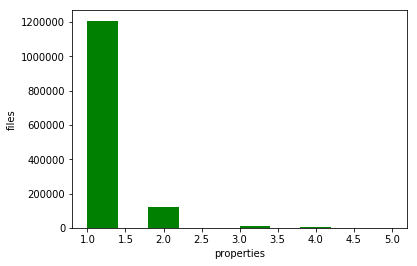

In [12]:
#plot the distribution
histogram=plt.hist(property_page_id['num_props'],color='green')
plt.xlabel('properties')
plt.ylabel('files')
                  

## Breakdown of individual Properties and the number of files that have them

In [16]:
property_page_id.sum().astype(int)

page_id                 71764543710329
has_label                       510485
has_depicts                     868276
has_creator                      59920
has_creation_date                 9214
has_publication_date                 0
has_license                      40146
has_digital_rep                  16616
num_props                      1504657
dtype: int64

**The numbers above make sense because properties like Captions (with 510,485 files) and Depicts (with 868,276 files), were first made available to update with structured data on Wiki Commons and users have continued to update files with those properties in the time from August to December 2019 **